## LeNet

LeNet[1] 即 LeNet5，于1988年提出，是最早的卷积神经网络之一。原论文的网络结构是用于训练手写数字的，本节尝试用 LeNet 训练 CIFAR-10 数据集，因此结构上会有点微调。一共有五层网络（不算输入层），两层卷积层和三层全连接层：
 + 第一层：卷积层
  + C：使用 6 个 $5\times5$ 的卷积核，步长为 1，非全 0 填充（valid）
  + B：不使用批标准化（LeNet 提出时间在 Batch Normalization[2] 提出时间之前）
  + A：使用 sigmoid 激活函数（那个时候是主流的激活函数）
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，非全 0 填充（valid）
  + D：不使用 Dropout（LeNet 提出时间在 Dropout[3] 提出时间之前）
 + 第二层：卷积层
  + C：使用 16 个 $5\times5$ 的卷积核，步长为 1，非全 0 填充（valid）
  + B：不使用批标准化
  + A：使用 sigmoid 激活函数
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，非全 0 填充（valid）
  + D：不使用 Dropout
 + Flatten 拉伸卷积层传来的输入特征 
 + 第三层：全连接层
  + 120 个神经元
  + 使用 sigmoid 激活函数 
 + 第四层：全连接层
  + 84 个神经元
  + 使用 sigmoid 激活函数
 + 第五层：全连接层（输出层）
  + 10 个神经元
  + 使用 softmax 激活函数

关于 CIFAR-10 数据集的信息可以看上一节。

+ [1] Lecun Y , Bottou L . Gradient-based learning applied to document recognition[J]. Proceedings of the IEEE, 1998, 86(11):2278-2324.
+ [2] Ioffe S , Szegedy C . Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift[J]. 2015.
+ [3] Srivastava N , Hinton G , Krizhevsky A , et al. Dropout: A Simple Way to Prevent Neural Networks from Overfitting[J]. Journal of Machine Learning Research, 2014, 15(1):1929-1958.

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

在上一版 baseline 的基础上，修改模型类即可，其他步骤的操作基本不改变。

In [2]:
class LeNet5(Model):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = Conv2D(filters=6, kernel_size=(5, 5), activation='sigmoid')
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2)
        
        self.c2 = Conv2D(filters=16, kernel_size=(5, 5), activation='sigmoid')
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2)
        
        self.flatten = Flatten()
        self.f1 = Dense(120, activation='sigmoid')
        self.f2 = Dense(84, activation='sigmoid')
        self.f3 = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.c1(x)
        x = self.p1(x)
        
        x = self.c2(x)
        x = self.p2(x)
        
        x = self.flatten(x)
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

In [3]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# LeNet5 
model = LeNet5()

In [5]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [6]:
# 设置断点续训
checkpoint_save_path = './checkpoint/LeNet5.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [7]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [8]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 26s 525us/sample - loss: 2.0492 - sparse_categorical_accuracy: 0.2279 - val_loss: 1.8164 - val_sparse_categorical_accuracy: 0.3197arse_c - ETA
Epoch 2/5
50000/50000 [==============================] - 30s 598us/sample - loss: 1.7288 - sparse_categorical_accuracy: 0.3565 - val_loss: 1.6128 - val_sparse_categorical_accuracy: 0.3988
Epoch 3/5
50000/50000 [==============================] - 32s 631us/sample - loss: 1.5775 - sparse_categorical_accuracy: 0.4175 - val_loss: 1.5036 - val_sparse_categorical_accuracy: 0.4420
Epoch 4/5
50000/50000 [==============================] - 28s 565us/sample - loss: 1.4895 - sparse_categorical_accuracy: 0.4509 - val_loss: 1.4669 - val_sparse_categorical_accuracy: 0.4613
Epoch 5/5
50000/50000 [==============================] - 26s 525us/sample - loss: 1.4358 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.4286 - val_sparse_categorical_accuracy: 0.474

In [9]:
# 打印网络结构
model.summary()

Model: "le_net5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  48120     
_________________________________________________________________
dense_1 (Dense)              multiple                  1016

In [10]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [11]:
# 可视化 acc 和 loss 曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

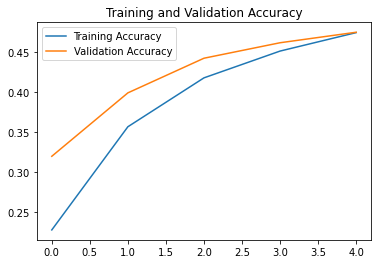

In [12]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

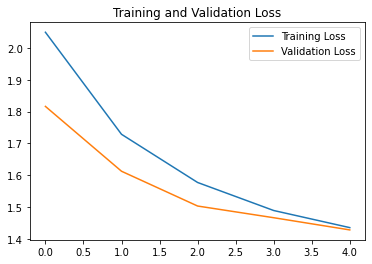

In [13]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()